Flower Recognition CNN Keras

連結google drive

In [1]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
#data = pd.read_csv("/content/gdrive/My Drive/已存在google雲端的檔名")

Mounted at /content/gdrive


In [2]:
#查看flowers資料夾
import os
print(os.listdir('./gdrive/MyDrive/陳煥作業/2/flowers'))

['daisy', 'sunflower', 'rose', 'tulip', 'dandelion']


1 ) Importing Various Modules.

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

2 ) Preparing the Data

2.1) Making the functions to get the training and validation set from the Images

In [4]:
X=[]#Training images
Z=[]#labels
IMG_SIZE=150
FLOWER_DAISY_DIR='./gdrive/MyDrive/陳煥作業/2/flowers/daisy'
FLOWER_SUNFLOWER_DIR='./gdrive/MyDrive/陳煥作業/2/flowers/sunflower'
FLOWER_TULIP_DIR='./gdrive/MyDrive/陳煥作業/2/flowers/tulip'
FLOWER_DANDI_DIR='./gdrive/MyDrive/陳煥作業/2/flowers/dandelion'
FLOWER_ROSE_DIR='./gdrive/MyDrive/陳煥作業/2/flowers/rose'

In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:14<00:00, 52.68it/s] 

764


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:14<00:00, 52.00it/s] 

1497


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:20<00:00, 47.75it/s] 

2481


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:19<00:00, 53.90it/s] 

3533


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:13<00:00, 60.11it/s] 

4317


2.2 ) Visualizing some Random Images

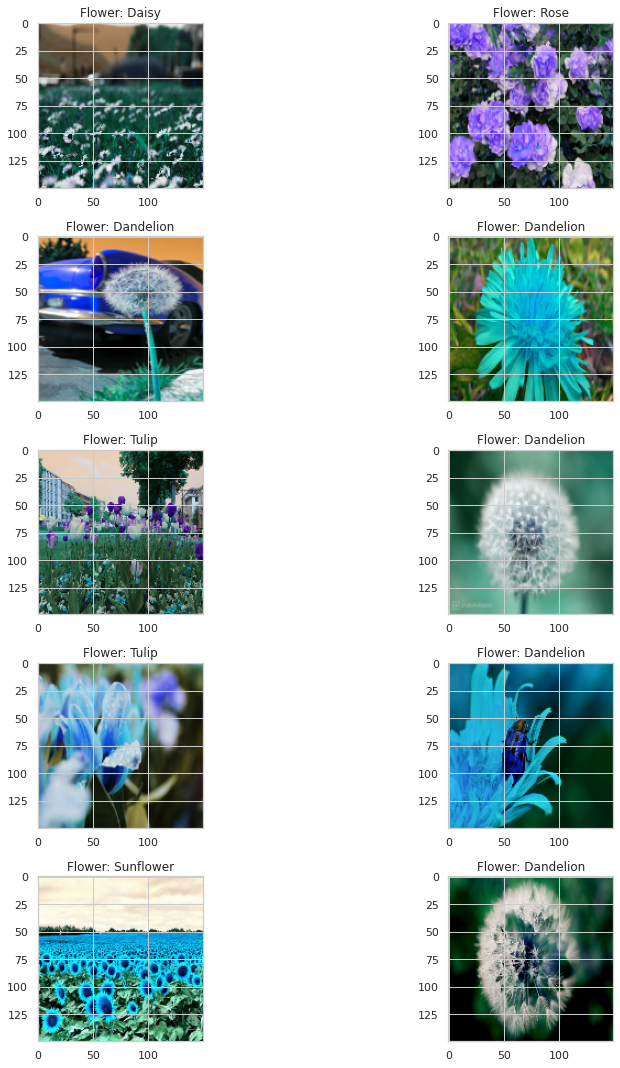

In [12]:
#印出5*2個隨機圖片
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [13]:
#label encoding
le=LabelEncoder()
Y=le.fit_transform(Z)
#One Hot Encoding
Y=to_categorical(Y,5)
# 特徵縮放，使用常態化(Normalization)，公式 = (x - min) / (max - min)
# 顏色範圍：0~255，所以，公式簡化為 x / 255
X=np.array(X)
X=X/255

2.4 ) Splitting into Training and Validation Sets

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

2.5 ) Setting the Random Seeds

In [15]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

3 ) Modelling

3.1 ) Building the ConvNet Model

In [16]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

3.2 ) Using a LR Annealer

In [17]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

3.3 ) Data Augmentation to prevent Overfitting

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

3.4 ) Compiling the Keras Model & Summary

In [19]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
# 顯示模型的彙總資訊
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [ ]:
# 模型訓練
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
25/25 [==============================] - 173s 7s/step - loss: 1.4557 - accuracy: 0.3586 - val_loss: 1.1960 - val_accuracy: 0.4648
Epoch 2/50
25/25 [==============================] - 167s 7s/step - loss: 1.2385 - accuracy: 0.4712 - val_loss: 1.0828 - val_accuracy: 0.5046
Epoch 3/50
25/25 [==============================] - 167s 7s/step - loss: 1.0883 - accuracy: 0.5674 - val_loss: 1.0215 - val_accuracy: 0.5935
Epoch 4/50
25/25 [==============================] - 167s 7s/step - loss: 1.0207 - accuracy: 0.5902 - val_loss: 0.9239 - val_accuracy: 0.6204
Epoch 5/50
25/25 [==============================] - 167s 7s/step - loss: 0.9478 - accuracy: 0.6301 - val_loss: 0.9392 - val_accuracy: 0.6333
Epoch 6/50
25/25 [==============================] - 166s 7s/step - loss: 0.9194 - accuracy: 0.6427 - val_loss: 0.8346 - val_accuracy: 0.6759
Epoch 7/50
25/25 [==============================] - 170s 7s/step - loss: 0.8620 - accuracy: 0.6697 - val_loss: 0.9497 - val_accuracy: 0.6213
Epoch 8/50
25

In [ ]:
# 模型存檔
model.save('./gdrive/MyDrive/陳煥作業/2/model.h5')

In [21]:
# 模型載入
model = tf.keras.models.load_model('./gdrive/MyDrive/陳煥作業/2/model.h5')

4 ) Evaluating the Model Performance

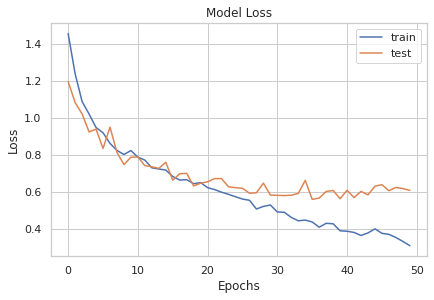

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

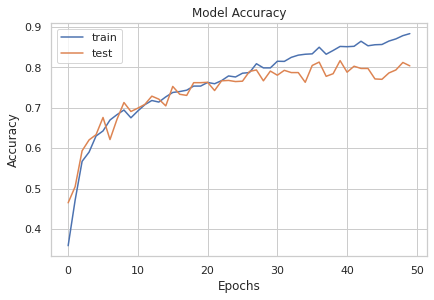

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

5 ) Visualizing some random images and predictons on the Validation Set

In [24]:
# getting predictions on val set.
pred=model.predict(x_test)#樣本屬於每一個類別的機率
pred_digits=np.argmax(pred,axis=1)#最大機率所屬的類別

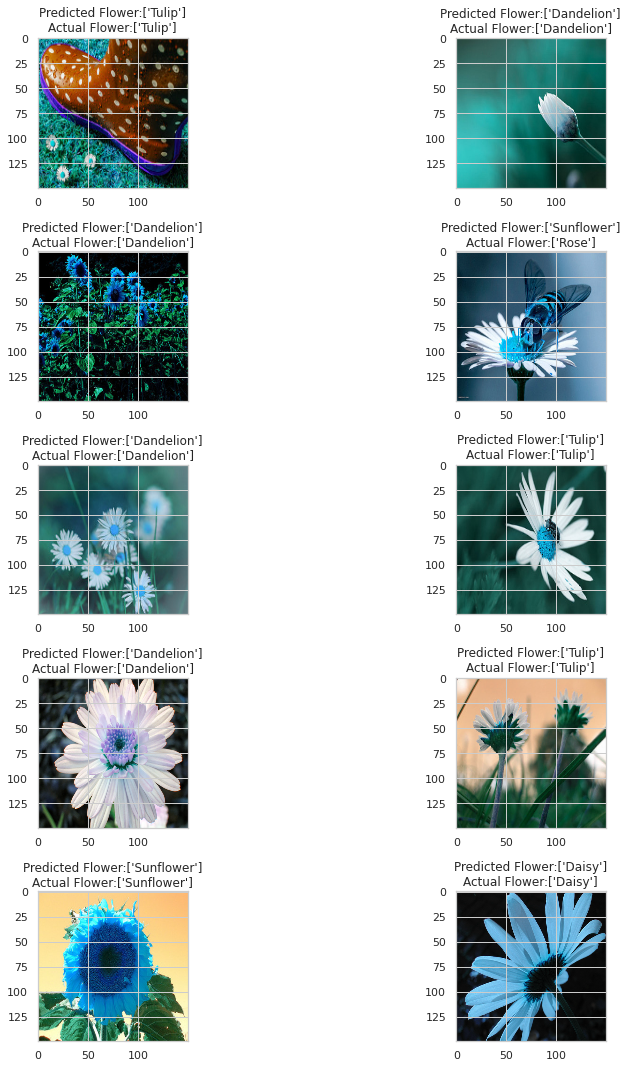

In [80]:
#印出5*2個隨機圖片
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(y_test))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title("Predicted Flower:"+str(le.inverse_transform([pred_digits[l]]))+"\n"+"Actual Flower:"+str(le.inverse_transform([np.argmax(y_test[l])])))

plt.tight_layout()